In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

import itertools

INF = float("inf")


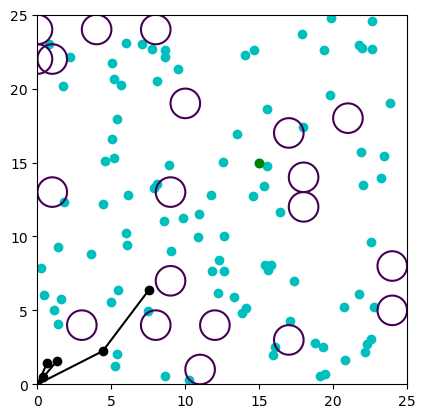

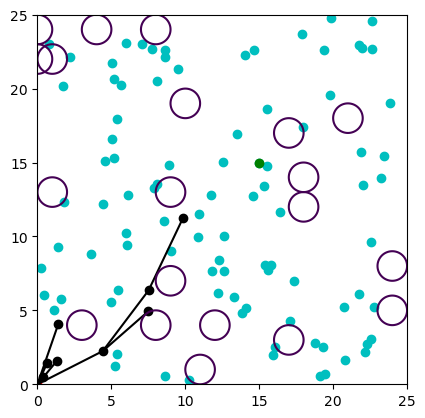

Step: 25 Path Length: 21.89750990521562 Planer: BIT*


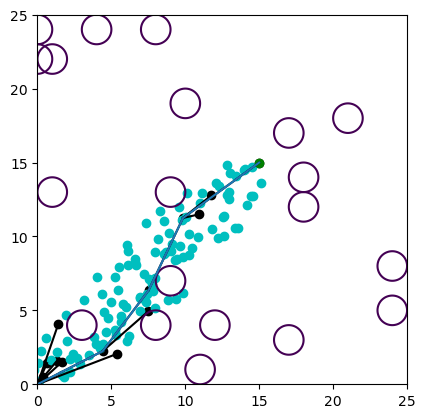

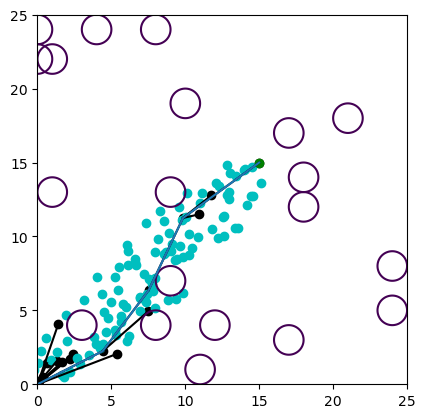

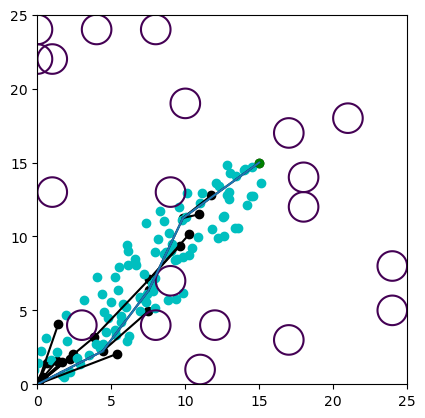

reach limit


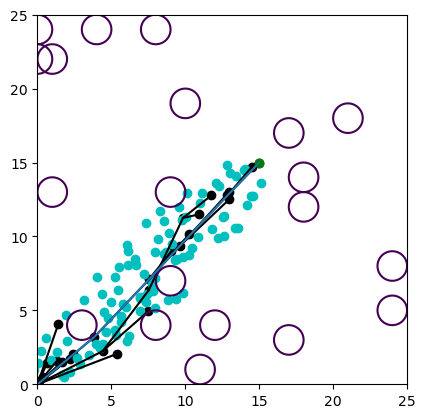

In [95]:
def distance(start,end):
    diff = np.array(start)-np.array(end)
    return np.linalg.norm(diff)
def plotCircle(xi,yi,r):
    x = np.linspace(xi-r, xi+r, 100)
    y = np.linspace(yi-r, yi+r, 100)
    X, Y = np.meshgrid(x,y)
    F = (X-xi)**2 + (Y-yi)**2
    plt.contour(X,Y,F,[r])


n = 2
class BIT(object):
    def __init__(self, start_p, end_p, candidates,obstacle):
        self.maxIter = 500
        self.start_p = start_p
        self.end_p = end_p
        self.dimension = 2
        # define the environment
        self.candidates = candidates
        self.obstacle = obstacle
        block_x,block_y = np.where(self.obstacle==1)
        self.block = np.vstack((block_x,block_y)).T
        # initialize the variable sets 
        self.Vertex = [start_p]
        self.Edge = dict() #key = kid, value = parent
        self.Xsample = [end_p]
        self.QEdge = []
        self.QVertex = []
        self.r = INF
        self.g_scores = dict()
        self.f_scores = dict()
        self.gT = dict()
        self.g_scores[start_p] = 0
        self.f_scores[end_p] = 0
        # self.g_scores.setdefault(None,INF)
        # self.f_scores.setdefault(None,INF)
        # self.gT.setdefault(None,INF)
        self.c = INF
        eta = 1
        self.unit_ball_volume = math.pi
        gamma = (1.0 + 1.0/n) * (25 - 0) * (25 - 0)/self.unit_ball_volume
        self.r_c = 2 * eta * (gamma**(1.0/n))
        self.c_min = distance(start_p,end_p)
        self.batch_size=100
        self.center_point = np.matrix([[(self.start_p[0] + self.end_p[0]) / 2.0],[(self.start_p[1] + self.end_p[1]) / 2.0], [0]])
        a_1 = np.matrix([[(self.end_p[0] - self.start_p[0]) / self.c_min],[(self.end_p[1] - self.start_p[1]) / self.c_min], [0]])
        id1_t = np.matrix([1.0,0,0])
        M = np.dot(a_1, id1_t)
        U,S,Vh = np.linalg.svd(M, 1, 1)
        self.C = np.dot(np.dot(U, np.diag([1.0,1.0,  np.linalg.det(U) * np.linalg.det(np.transpose(Vh))])), Vh)
    def get_best_path(self):
        path = []
        if self.get_g_score(self.end_p) != INF:
            path.append(self.end_p)
            point = self.end_p
            while point != self.start_p:
                point = self.Edge[point]
                path.append(point)
            path.reverse()
        return path
    def get_point_value(self,point):
        # sort value for point
        return self.get_g_score(point)+self.heuristic_cost(point,self.end_p)
    def get_edge_value(self,edge):
        # sort value for edge
        return self.get_g_score(edge[0])+self.heuristic_cost(edge[0],edge[1])+self.heuristic_cost(edge[1],self.end_p)
    def heuristic_cost(self, point1, point2):
        # Euler distance as the heuristic distance
        return distance(point1, point2)
    def bestVertexQueueValue(self):
        if len(self.QVertex)<1:
            return INF
        else:
            return self.QVertex[0][0]
    def bestEdgeQueueValue(self):
        if len(self.QEdge)<1:
            return INF
        else:
            return self.QEdge[0][0]
    def prune(self,c_best):
        self.Xsample = [point for point in self.Xsample if self.get_f_score(point)<=c_best]
        self.Vertex = [point for point in self.Vertex if self.get_f_score(point)<=c_best]
       

        edge_array = list(self.Edge.items())
        for point, parent in edge_array:
            if self.get_f_score(point) > c_best or self.get_f_score(parent) > c_best:
                self.Edge.pop(point)
        for point in self.Vertex:
            if self.get_f_score(point)==INF:
                self.Vertex.pop(point)
                
        vertices_temp = []
        for point in self.Vertex:
            if self.get_f_score(point) <= c_best:
                if self.get_g_score(point)==INF:
                    self.Xsample.append(point)
                else:
                    vertices_temp.append(point)
        self.Vertex = vertices_temp
    def actual_edge_cost(self, point1, point2):
        # c(x1,x2)
        if self.checkCollision(point1,point2) or self.checkCollision(point2,point1):
            return INF
        return distance(point1, point2)
    def get_g_score(self, point):
        # gT(x)
        if point == self.start_p:
            return 0
        if point not in self.Edge:
            return INF
        else:
            return self.g_scores.get(point)

    def get_f_score(self, point):
        # f^(x)
        return self.heuristic_cost(self.start_p,point) + self.heuristic_cost(point, self.end_p)
    def getheuristicG(self,point):
        return distance(point,self.end_p)+self.gT[point]
    
    def sample_unit_ball(self):
        a = np.random.random()
        b = np.random.random()
        if b < a:
            a,b=b,a
        sample = (b*math.cos(2*math.pi*a/b), b*math.sin(2*math.pi*a/b))
        return np.array([[sample[0]], [sample[1]], [0]])
    def plot_function(self, path):
        plt.figure()
        plt.xlim(0,25)
        plt.ylim(0,25)
        ax = plt.subplot()
        for k,v in self.Edge.items():
        
            plt.plot([k[0],v[0]],[k[1],v[1]],c='black')
            plt.scatter(k[0],k[1],c='black')
        sample = np.array(self.Xsample)
        plt.scatter(sample[:,0],sample[:,1],c='c')
        for xi,yi in zip(self.block[:,0],self.block[:,1]): # plot obstacle
            plotCircle(xi,yi,r=1)
        plt.scatter(self.start_p[0],self.start_p[1], c='r')
        plt.scatter(self.end_p[0],self.end_p[1],c='g')
        ax.set_aspect('equal')
        if len(path)>0:
            path = np.array(path)
            plt.plot(path[:,0],path[:,1])
    def informed_sample(self, c_best, sample_num):
        if c_best < float('inf'):
            c_b = math.sqrt(c_best**2 - self.c_min**2)/2.0
            r= [c_best /2.0, c_b, c_b]
            L = np.diag(r)
        sample_array = []
        cur_num = 0
        while cur_num < sample_num:
            if c_best < float('inf'):
                x_ball = self.sample_unit_ball()
                random_point = np.dot(np.dot(self.C,L), x_ball) + self.center_point
                random_point = (random_point[(0,0)], random_point[(1,0)])
                if self.checkPointCollision(random_point):
                    continue
            else:
                random_point = self.free_sample()
            cur_num += 1
            sample_array.append(random_point)
        return sample_array
    def free_sample(self):
        crash = True
        while (crash):
            x = np.random.uniform(0,self.obstacle.shape[0])
            y = np.random.uniform(0,self.obstacle.shape[1])
            crash = self.checkPointCollision((x,y))
        return (x,y)
    def checkPointCollision(self,point):
        diff = self.block-np.array(point)
        ds = np.linalg.norm(diff,2,axis=1)
        return (ds<1).any()  
    def checkCollision(self,xnew,xnear,step=1):
        x,y = np.where(self.obstacle==1)
        crash = False

        for i,j in zip(x,y):
            r1 = [xnew[0]-i,xnew[1]-j]
            r2 = [xnear[0]-i,xnear[1]-j]
            r1_r =distance(xnew,(i,j))
            r2_r =distance(xnear,(i,j))
            if r1_r<=step or r2_r<=step:
                crash = True
                return crash
            r1r2 = (r1[0]*r2[0]+r1[1]*r2[1])
            d = ((r1_r**2)*(r2_r**2)-(r1r2)**2)/(distance(xnew,xnear)**2)
            if d <=step**2 and i>=min(xnew[0],xnear[0]) and i<max(xnew[0],xnear[0]):
                crash = True
                return crash
        return crash
    def expandVertex(self,point):
        # get the nearest value in vertex for every one in samples where difference is less than the radius
        neigbors_sample = []
        for sample in self.Xsample:
            d = distance(point,sample)
            if d <= self.r:
                neigbors_sample.append(sample)

        # add an edge to the edge queue is the path might improve the solution
        for neighbor in neigbors_sample:
            estimated_f_score = distance(self.start_p,point) + \
                distance(point, neighbor) + distance(neighbor, self.end_p)
            if estimated_f_score < self.get_g_score(self.end_p):
                self.QEdge.append((estimated_f_score,(point,neighbor)))

        # add the vertex to the edge queue
        if point not in self.oldVertex:
            neigbors_vertex = []
            for ver in self.Vertex:
                if distance(point,ver) <= self.r:
                    neigbors_vertex.append(ver)
            for neighbor in neigbors_vertex:
                if neighbor not in self.Edge or point != self.Edge.get(neighbor):
                    estimated_f_score = distance(self.start_p, point) + \
                        distance(point, neighbor) + distance(neighbor, self.end_p)
                    if estimated_f_score < self.get_g_score(self.end_p):
                        estimated_g_score = self.get_g_score(point) + distance(point, neighbor)
                        if estimated_g_score < self.get_g_score(neighbor):
                            self.QEdge.append((self.get_edge_value((point,neighbor)),(point,neighbor)))
        return
    
    def plan(self):
        path = []
        for i in range(self.maxIter):
            if  len(self.QVertex)<1 and len(self.QEdge)<1:
                c_best = self.get_g_score(self.end_p)
                self.prune(c_best)
                self.Xsample.extend(self.informed_sample(c_best, self.batch_size))

                self.oldVertex = set(self.Vertex)
                self.QVertex = [(self.get_point_value(point),point) for point in self.Vertex]
                q = len(self.Vertex)+len(self.Xsample)
                self.r = self.r_c * ((math.log(q) / q) ** (1.0/self.dimension))
            self.QVertex = sorted(self.QVertex)
            self.QEdge = sorted(self.QEdge)
            while self.bestVertexQueueValue() <= self.bestEdgeQueueValue():
                _, point = self.QVertex.pop(0)
                self.expandVertex(point)

                 


            self.QEdge=sorted(self.QEdge)
            best_edge_value, bestEdge = self.QEdge.pop(0)

            # Check if this can improve the current solution
            if best_edge_value < self.get_g_score(self.end_p):
                actual_cost_of_edge = self.actual_edge_cost(bestEdge[0], bestEdge[1])
                actual_f_edge = self.heuristic_cost(self.start_p, bestEdge[0]) + actual_cost_of_edge + self.heuristic_cost(bestEdge[1], self.end_p)
                if actual_f_edge < self.get_g_score(self.end_p):
                    actual_g_score_of_point = self.get_g_score(bestEdge[0]) + actual_cost_of_edge
                    if actual_g_score_of_point < self.get_g_score(bestEdge[1]):
                        self.g_scores[bestEdge[1]] = actual_g_score_of_point
                        self.Edge[bestEdge[1]] = bestEdge[0]
                        if bestEdge[1] not in self.Vertex:
                            self.Xsample.remove(bestEdge[1])
                            self.Vertex.append(bestEdge[1])
                            self.QVertex.append((self.get_point_value(bestEdge[1]),bestEdge[1]))
                        
                      
                        QEdge_tmp = [ item for item in self.QEdge if item[1][1]!=bestEdge[1] or \
                                            self.get_g_score(item[1][0]) + self.heuristic_cost(item[1][0],item[1][1])<self.get_g_score(item[1][0]) ]
                        self.QEdge.clear()
                        self.QEdge = QEdge_tmp.copy()
                        #self.QEdge = sorted(self.QEdge)      # Rebuild the priority queue because it will be destroyed after the element is removed

            else:
                self.QVertex= []
                self.QEdge = []
                print("Step:", i, "Path Length:", self.g_scores[self.end_p], "Planer: BIT*")
            if i%10==0 and i>0:
                path = self.get_best_path()
                self.plot_function(path)
                plt.show()
            if self.get_g_score(self.end_p) <= distance(self.start_p,self.end_p)+0.5:
                print ("reach limit")
                path = self.get_best_path()
                self.plot_function(path)
                
                plt.show()
                break
        
# intialize environment
def initialObstacle(obstacle):
    x = np.random.choice(len(obstacle),20)
    y = np.random.choice(len(obstacle[0]),20)
    
    for i,j in zip(x,y):
        if i**2+j**2<=1 or (i-15)**2+(j-15)**2<=1:
            continue
        obstacle[i][j] = 1
    return np.array(obstacle),np.vstack((x,y))
x_width = 25
y_width = 25
obstacle = [[0 for j in range(x_width)] for i in range(0,y_width)]
obstacle,blocks = initialObstacle(obstacle)
x0,y0 = 0,0
xn,yn = 15,15
step = 1
obstacle[x0][y0] = 2
obstacle[xn][yn] = 3
candidates = list(itertools.product(range(x_width),range(y_width)))
#initialize BIT
bit_search = BIT(start_p = (x0,y0),end_p = (xn,yn),candidates = candidates, obstacle = obstacle )
bit_search.plan()
        
